<a href="https://colab.research.google.com/github/mahdeslami11/pe/blob/main/PRC_GFN_UCM_UNET-3D_PATCH_FULLY3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DEEP POSITRON RANGE CORRECTION WITH PATCHES - FULLY3D CONFERENCE
# J.L.Herraiz et al. GFN - UCM - 2021

## STEP 1 ) Load Libraries

In [ ]:
import tensorflow as tf
tf.version.VERSION

'2.4.0'

In [ ]:
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import cv2
import sklearn.model_selection as sk

In [ ]:
#!pip install -q tfa-nightly
import tensorflow_addons as tfa

C:\Users\herra\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.4.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(
C:\Users\herra\anaconda3\lib\site-packages\typeguard\__init__.py:885: UserWarning: no type annotations present -- not typechecking tensorflow_addons.layers.max_unpooling_2d.MaxUnpooling2D.__init__
  warn('no type annotations present -- not typechecking {}'.format(function_name(

## IMAGE PARAMETERS

In [ ]:
# PARAMETROS DE LAS IMAGENES
Nx0 = 154
Ny0 = 154
Nz0 = 80
Nt1 = 7
Nt2 = 8
Nt = Nt1+Nt2
dx = 0.0280
dy = 0.0280
dz = 0.0280    #VOXEL SIZE (cm) ALONG X,Y,Z

# EXTENDED FOV TO MAKE IT MORE DIVISIBLE (PADDED WITH ZEROS)
Nx1 = 160
Ny1 = 160
Nz1 = 81

In [ ]:
ksize_planes = 9
ksize_rows = 32
ksize_cols = 32

stride_planes = 4
strides_rows = 16
strides_cols = 16

ksizes = [1, ksize_planes, ksize_rows, ksize_cols, 1]         #The size of the sliding window for each dimension of input.
strides = [1, stride_planes, strides_rows, strides_cols, 1]   #How far the centers of two consecutive patches are in input.
padding = "VALID"

In [ ]:
# EXTENDED FOV
# FROM EACH PATCH WE EXTRACT 16X16X1 OUTPUT --> THEFORE WE NEED ADDITIONAL 8X8X4 IN EACH EDGE
outputx = ksize_rows//2  #16
outputy = ksize_cols//2  #16
outputz = 1
Zc = ksize_planes//2 #4

extrax = ksize_rows - outputx
extray = ksize_cols - outputy
extraz = ksize_planes - 1

Nx2=Nx1 + extrax
Ny2=Ny1 + extray
Nz2=Nz1 + extraz

Npatchesx = Nx1 // outputx
Npatchesy = Ny1 // outputy

## LOAD IMAGES


In [ ]:
URL = 'https://tomografia.es/data/Ga68_V2_ALL.raw'
PATH_Ga68_V2 = tf.keras.utils.get_file('Ga68_V2.raw',origin=URL)
Ga68_V2_file = np.fromfile(PATH_Ga68_V2, dtype='float32')
Ga68_V2 = Ga68_V2_file.reshape((Nt2,Nz0,Ny0,Nx0))

In [ ]:
URL = 'https://tomografia.es/data/F18_V2_ALL.raw'
PATH_F18_V2 = tf.keras.utils.get_file('F18_V2_ALL.raw',origin=URL)
F18_V2_file = np.fromfile(PATH_F18_V2, dtype='float32')
F18_V2 = F18_V2_file.reshape((Nt2,Nz0,Ny0,Nx0))

In [ ]:
URL = 'https://tomografia.es/data/MUNORM_V2_ALL.raw'
PATH_MU_V2 = tf.keras.utils.get_file('MUNORM_V2_ALL.raw',origin=URL)
MU_V2_file = np.fromfile(PATH_MU_V2, dtype='float32')
MU_V2 = MU_V2_file.reshape((Nt2,Nz0,Ny0,Nx0))

## NORMALIZATION OF MUNORM (GLOBAL)

In [ ]:
MAXM = np.max(MU_V2)
MUN = MU_V2/MAXM
print(MAXM)

0.27039027


## PATCHES FROM VOLUME

In [ ]:
Ga68_tf = tf.convert_to_tensor(Ga68_V2, tf.float32)
Ga68_tf = tf.image.pad_to_bounding_box(Ga68_tf,stride_planes,0,Nz2,Nx0)
Ga68_tf = tf.transpose(Ga68_tf, perm=[0,2,3,1])
Ga68_tf = tf.image.pad_to_bounding_box(Ga68_tf,3+strides_rows,3+strides_cols,Nx2,Ny2)
Ga68_tf = tf.transpose(Ga68_tf, perm=[0,3,1,2])
Ga68_tf = tf.expand_dims(Ga68_tf,axis=-1)   #5-D Tensor with shape [batch, in_planes, in_rows, in_cols, depth].
Ga68_tf_patches = tf.extract_volume_patches(Ga68_tf,ksizes,strides,padding)   #Extract patches from input and put them in the "depth" output dimension.

F18_tf = tf.convert_to_tensor(F18_V2, tf.float32)
F18_tf = tf.image.pad_to_bounding_box(F18_tf,stride_planes,0,Nz2,Nx0)
F18_tf = tf.transpose(F18_tf, perm=[0,2,3,1])
F18_tf = tf.image.pad_to_bounding_box(F18_tf,3+strides_cols,3+strides_cols,Nx2,Ny2)
F18_tf = tf.transpose(F18_tf, perm=[0,3,1,2])
F18_tf = tf.expand_dims(F18_tf,axis=-1)   #5-D Tensor with shape [batch, in_planes, in_rows, in_cols, depth].
F18_tf_patches = tf.extract_volume_patches(F18_tf,ksizes,strides,padding)   #Extract patches from input and put them in the "depth" output dimension.

MU_tf = tf.convert_to_tensor(MUN, tf.float32)
MU_tf = tf.image.pad_to_bounding_box(MU_tf,stride_planes,0,Nz2,Nx0)
MU_tf = tf.transpose(MU_tf, perm=[0,2,3,1])
MU_tf = tf.image.pad_to_bounding_box(MU_tf,3+strides_cols,3+strides_cols,Nx2,Ny2)
MU_tf = tf.transpose(MU_tf, perm=[0,3,1,2])
MU_tf = tf.expand_dims(MU_tf,axis=-1)   #5-D Tensor with shape [batch, in_planes, in_rows, in_cols, depth].
MU_tf_patches = tf.extract_volume_patches(MU_tf,ksizes,strides,padding)   #Extract patches from input and put them in the "depth" output dimension.

## MAX OF EACH INPUT PATCH

In [ ]:
Ga = tf.reshape(Ga68_tf_patches,[-1,Ga68_tf_patches.shape[4]])
Ga_max = tf.math.reduce_max(Ga,1)+tf.constant(1.0e-5)  #Avoid division by zero if patch is null
Ga_max = tf.expand_dims(Ga_max,axis=-1)
maximo = tf.tile(Ga_max,tf.constant([1,Ga.shape[1]], tf.int32))

## NORMALIZE EACH PATCH AND RESHAPE

In [ ]:
Ga = tf.divide(Ga,maximo)
Ga = tf.reshape(Ga,[Ga.shape[0],ksize_planes,ksize_rows,ksize_cols])
Ga = tf.transpose(Ga, perm=[0, 2, 1, 3])
Ga = tf.transpose(Ga, perm=[0, 1, 3, 2])
Ga68 = Ga.numpy()

M = tf.reshape(MU_tf_patches,[-1,MU_tf_patches.shape[4]])
M = tf.reshape(M,[M.shape[0],ksize_planes,ksize_rows,ksize_cols])
M = tf.transpose(M, perm=[0, 2, 1, 3])
M = tf.transpose(M, perm=[0, 1, 3, 2])
MU = M.numpy()

F = tf.reshape(F18_tf_patches,[-1,F18_tf_patches.shape[4]])
F = tf.divide(F,maximo)
F = tf.reshape(F,[F.shape[0],ksize_planes,ksize_rows,ksize_cols])
F = tf.transpose(F, perm=[0, 2, 1, 3])
F = tf.transpose(F, perm=[0, 1, 3, 2])
F18 = F[:,:,:,Zc:Zc+1].numpy()
Ga68.shape

(16800, 32, 32, 9)

## INPUT  /  OUTPUT

4-D Tensor of shape [batch, height, width, channels]

In [ ]:
inp_np = Ga68  #np.concatenate((Ga68,MU),axis=-1)
out_np = F18
Npatches = F18.shape[0]  # Number of patches

## SPLIT DATA INTO TRAIN AND VALIDATION

In [ ]:
x_train, x_val, y_train, y_val = sk.train_test_split(inp_np, out_np, test_size=0.3, shuffle=True)

## NUMPY TO TENSOR

In [ ]:
x_train_tf = tf.convert_to_tensor(x_train, tf.float32)
x_val_tf = tf.convert_to_tensor(x_val, tf.float32)
y_train_tf = tf.convert_to_tensor(y_train, tf.float32)
y_val_tf = tf.convert_to_tensor(y_val, tf.float32)
x_train_tf.shape

TensorShape([11760, 32, 32, 9])

## SHOW EXAMPLE

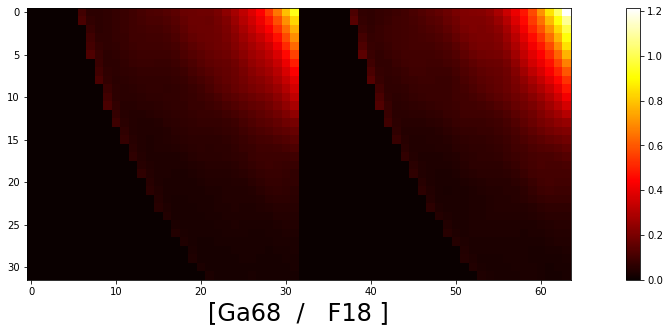

In [ ]:
k=17    #SLICE
images = np.concatenate((x_val_tf[k,:,:,Zc], y_val_tf[k,:,:,0]), axis=1)

fig, ax = plt.subplots(figsize=(20,5))
im = ax.imshow(images,cmap='hot')
_ = fig.colorbar(im, ax=ax)
_ = ax.set_xlabel('[Ga68  /   F18 ]', fontsize=24)

# U-NET

In [ ]:
from keras_unet.models import custom_unet
from keras_unet.utils import get_augmented

#from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
#from keras_unet.metrics import iou
#from tensorflow.keras.optimizers import Adam, SGD

In [ ]:
train_gen = get_augmented(x_train_tf, y_train_tf, batch_size=64,
    data_gen_args = dict(horizontal_flip=True,vertical_flip=True))

C:\Users\herra\anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:938: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (11760, 32, 32, 9) (9 channels).
  warnings.warn(
C:\Users\herra\anaconda3\lib\site-packages\keras_preprocessing\image\numpy_array_iterator.py:129: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (11760, 32, 32, 9) (9 channels).
  warnings.warn('NumpyArrayIterator is set to use the '


In [ ]:
model = custom_unet(
    input_shape=(x_train_tf.shape[1], x_train_tf.shape[2], x_train_tf.shape[3]),
    use_batch_norm=True,
    activation='swish',
    filters=64,
    num_layers=4,
    use_attention=True,
    dropout=0.2,
    output_activation='relu')

In [ ]:
opt = tfa.optimizers.RectifiedAdam(lr=1e-3)
opt = tfa.optimizers.Lookahead(opt)

In [ ]:
L1 = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)
L2 = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)

In [ ]:
def make_my_loss():
    def my_loss(y_true, y_pred):
        yt = tf.image.central_crop(y_true,0.5)   # TRAIN WITH THE CENTRAL PART OF THE PATCH
        yp = tf.image.central_crop(y_pred,0.5)   # TRAIN WITH THE CENTRAL PART OF THE PATCH
        return L1(yt, yp)
    return my_loss

In [ ]:
my_loss = make_my_loss()

In [ ]:
model.compile(optimizer=opt,loss=my_loss)

In [ ]:
history = model.fit(train_gen,steps_per_epoch=100, epochs=200, validation_data=(x_val_tf, y_val_tf))

Epoch 1/100
100/100 [==============================] - 26s 105ms/step - loss: 0.2682 - val_loss: 0.1456
Epoch 2/100
100/100 [==============================] - 10s 100ms/step - loss: 0.0533 - val_loss: 0.0730
Epoch 3/100
100/100 [==============================] - 10s 100ms/step - loss: 0.0375 - val_loss: 0.0504
Epoch 4/100
100/100 [==============================] - 10s 100ms/step - loss: 0.0265 - val_loss: 0.0296
Epoch 5/100
100/100 [==============================] - 10s 101ms/step - loss: 0.0254 - val_loss: 0.0214
Epoch 6/100
100/100 [==============================] - 10s 101ms/step - loss: 0.0246 - val_loss: 0.0164
Epoch 7/100
100/100 [==============================] - 10s 100ms/step - loss: 0.0230 - val_loss: 0.0188
Epoch 8/100
100/100 [==============================] - 10s 101ms/step - loss: 0.0221 - val_loss: 0.0289
Epoch 9/100
100/100 [==============================] - 10s 101ms/step - loss: 0.0234 - val_loss: 0.0133
Epoch 10/100
100/100 [==============================] - 10s 100m

<ipython-input-55-15d81941667f>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


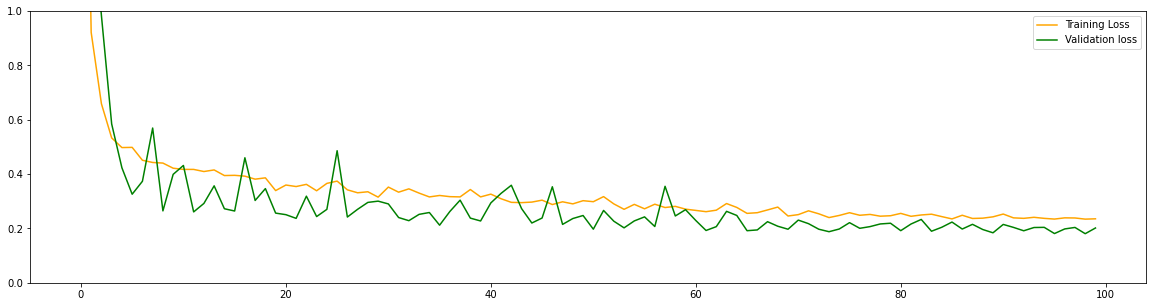

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))

loss = np.array(history.history['loss'])
var_loss = np.array(history.history['val_loss'])
ax.plot(20*np.log(1+loss), 'orange', label='Training Loss')
ax.plot(20*np.log(1+var_loss), 'green', label='Validation loss')
ax.set_ylim([0, 1])
ax.legend()
fig.show()

## SAVE LOSS HISTORY

In [ ]:
loss = np.array(history.history['loss'])
var_loss = np.array(history.history['val_loss'])
loss_info = np.transpose(100*np.array([loss,var_loss]))
np.savetxt(("LOSS_%d.csv" % 0), loss_info, fmt='%.3f', delimiter='\t')

## SAVE MODEL

In [ ]:
# Save the entire model as a HDF5 file.
model.save('PRC_FULLY3D.h5')

## RESTORING MODEL

In [ ]:
new_model = tf.keras.models.load_model('PRC_FULLY3D.h5',compile=False)   # LOADING KERAS MODEL
opt = tfa.optimizers.RectifiedAdam(lr=1e-3)
opt = tfa.optimizers.Lookahead(opt)
new_model.compile(optimizer=opt,loss='MeanAbsoluteError')

Text(0.5, 1.0, 'F18')

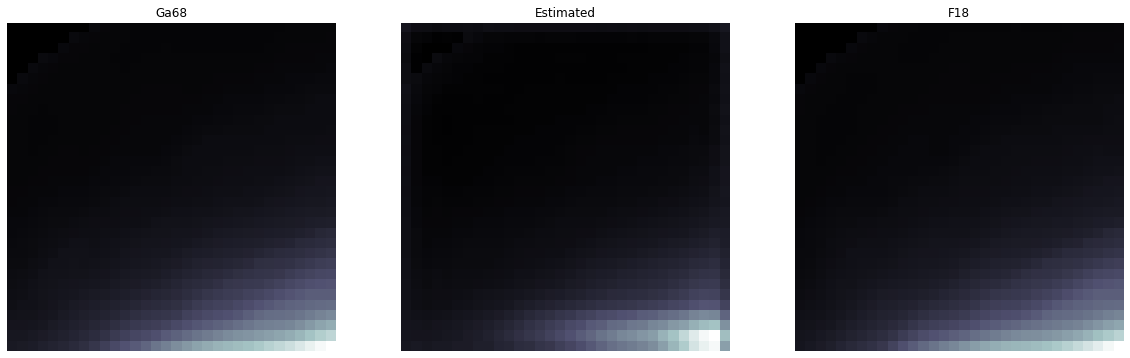

In [ ]:
img_index = 34
test = np.expand_dims(x_val[img_index,:,:,:],axis=0)
estim = new_model.predict(test)
Ga68_img = np.squeeze(test[:,:,:,Zc])
estim_img = np.squeeze(estim[:,:,:,0])
F18_img = np.squeeze(y_val[img_index,:,:,0])

plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
plt.imshow(Ga68_img, cmap=plt.cm.bone)
plt.axis('off')
plt.title('Ga68')

plt.subplot(1,3,2)
plt.imshow(estim_img, cmap=plt.cm.bone)
plt.axis('off')
plt.title('Estimated')

plt.subplot(1,3,3)
plt.imshow(F18_img, cmap=plt.cm.bone)
plt.axis('off')
plt.title('F18')

## DEPLOYMENT - STEP 1 ) ADAPTING INPUT --> PATCHES

In [ ]:
import time
t0 = time.time()

TGa68 = Ga68_V2[0,:,:,:]
TGa68_tf = tf.convert_to_tensor(TGa68, tf.float32)
TGa68_tf = tf.expand_dims(TGa68_tf,axis=0)
Tstride_planes = 1
TGa68_tf = tf.image.pad_to_bounding_box(TGa68_tf,stride_planes,0,Nz2,Nx0)
TGa68_tf = tf.transpose(TGa68_tf, perm=[0,2,3,1])
TGa68_tf = tf.image.pad_to_bounding_box(TGa68_tf,3+strides_rows//2,3+strides_cols//2,Nx2,Ny2)
TGa68_tf = tf.transpose(TGa68_tf, perm=[0,3,1,2])
TGa68_tf = tf.expand_dims(TGa68_tf,axis=-1)                     # 5-D Tensor with shape [batch, in_planes, in_rows, in_cols, depth].

Tstrides = [1, Tstride_planes, strides_rows, strides_cols, 1]   # How far the centers of two consecutive patches are in input.
TGa68_tf_patches = tf.extract_volume_patches(TGa68_tf,ksizes,Tstrides,padding)   #Extract patches from input and put them in the "depth" output dimension.
TGa68_tf_patches.shape

TGa = tf.reshape(TGa68_tf_patches,[-1,TGa68_tf_patches.shape[4]])
TGa_max = tf.math.reduce_max(TGa,1)+tf.constant(1.0e-5)
TGa_max = tf.expand_dims(TGa_max,axis=-1)
Tmaximo = tf.tile(TGa_max,tf.constant([1,TGa.shape[1]], tf.int32))

TGa = tf.divide(TGa,Tmaximo)
TGa = tf.reshape(TGa,[TGa.shape[0],ksize_planes,ksize_rows,ksize_cols])
TGa = tf.transpose(TGa, perm=[0, 2, 3, 1])

TGa.shape

TensorShape([8100, 32, 32, 9])

## DEPLOYMENT - STEP 2 ) NORMALIZATION INPUT

In [ ]:
Tmaxim2 = tf.tile(TGa_max,tf.constant([1,ksize_rows*ksize_cols//4], tf.int32))
Tmaxim2 = tf.reshape(Tmaxim2,[Tmaxim2.shape[0],ksize_rows//2,ksize_cols//2,1])
Tmaxim2.shape

TensorShape([8100, 16, 16, 1])

## DEPLOYMENT - STEP 3 ) MODEL PREDICT

In [ ]:
t1 = time.time()
TEst = model.predict(TGa)
t2 = time.time()
TEst = tf.image.central_crop(TEst,0.5)   # KEEP JUST THE CENTRAL PART
TEst = tf.multiply(TEst,Tmaxim2)  #Restore Normalization    #SHAPE 8100,16,16,1
TEst2 = tf.reshape(TEst,[-1,Npatchesy,Npatchesx,16,16])     #SHAPE 81X10X10X16X16
TEst3 = tf.transpose(TEst2,perm=[0,1,3,2,4])                #SHAPE 81X10X16X10X16   (REMEMBER: VOLUME [Z,Y,X] ORDER)
TEst3 = tf.reshape(TEst3,[-1,Ny1,Nx1])                      #SHAPE 81X160X160
print(t2-t1)

2.8044540882110596


## SAVING RESULT
Raw format (Nx0 = 154, Ny0 = 154, Nz0 = 80) Float32

In [ ]:
d = np.array(TGa68,'float32')
f=open("Initial.raw","wb")
f.write(d)
f.close()

In [ ]:
d = np.array(F18_V2[0,:,:,:],'float32')
f=open("Reference.raw","wb")
f.write(d)
f.close()

In [ ]:
d = np.squeeze(np.array(TEst3[0:Nz0,3:157,3:157],'float32'))
f=open("Corrected.raw","wb")
f.write(d)
f.close()